In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [15]:
from utils.genprodUtils.generators import Generator
from utils.genprodUtils.kinematics import two_body_decay, random_decay

class Signal(Generator):

    def __init__(self, m_x, m_y, **kwargs):
        assert m_x > 2 * m_y , "m_x must be greater than 2 * m_y"
        self.m_x , self.m_y = m_x, m_y

        super().__init__(
            dict(
                pt=lambda n : np.random.lognormal(np.log(100), 1, n),
                eta=lambda n : np.random.uniform(-2.5, 2.5, n),
                phi=lambda n : np.random.uniform(-np.pi, np.pi, n),
                mass=lambda n : np.random.normal(m_x, 0.1*m_x, n),
            ),
            **kwargs
        )

    def valid(self, event):
        self.y = np.random.lognormal( np.log(self.m_y), 0.2, size=(len(event), 2) )
        self.j = np.random.lognormal( np.log(10), 0.5, size=(len(event), 2, 2) )
        mask = (event.mass > np.sum(self.y, axis=1)) & np.all( self.y > np.sum(self.j, axis=-1), axis=1 )

        self.y = self.y[mask]
        self.j = self.j[mask]

        return mask

    
    def physics(self, event):
        y1, y2 = two_body_decay(event, *self.y.T)

        y1j1, y1j2 = two_body_decay(y1, *self.j[:,0].T)
        y2j1, y2j2 = two_body_decay(y2, *self.j[:,1].T)

        jet = ak.concatenate([ j[:,None] for j in [y1j1, y1j2, y2j1, y2j2] ], axis=1)
        jet = jet[ak.argsort(-jet.pt, axis=1)]

        return dict(
            mx=np.ones(len(event)) * self.m_x,
            my=np.ones(len(event)) * self.m_y,
            class_label=np.ones(len(event)),
            
            jet_pt=jet.pt,
            jet_eta=jet.eta,
            jet_phi=jet.phi,
            jet_m=jet.m,

            y1_pt=y1.pt,
            y1_eta=y1.eta,
            y1_phi=y1.phi,
            y1_m=y1.m,

            y2_pt=y2.pt,
            y2_eta=y2.eta,
            y2_phi=y2.phi,
            y2_m=y2.m,
        )

In [16]:
class Background(Generator):
    def __init__(self, **kwargs):
        super().__init__(
            dict(
                pt=lambda n : np.random.lognormal(np.log(100), 1, n),
                eta=lambda n : np.random.uniform(-2.5, 2.5, n),
                phi=lambda n : np.random.uniform(-np.pi, np.pi, n),
                mass=lambda n : np.random.lognormal( np.log(400), 1, n),
            ),
            **kwargs
        )

    def valid(self, event):
        self.y = np.random.lognormal( np.log(50), 1, size=(len(event), 2) )
        self.j = np.random.lognormal( np.log(10), 0.5, size=(len(event), 2, 2) )
        mask = (event.mass > np.sum(self.y, axis=1)) & np.all( self.y > np.sum(self.j, axis=-1), axis=1 )

        self.y = self.y[mask]
        self.j = self.j[mask]

        return mask

    def physics(self, event):
        y1, y2 = two_body_decay(event, *self.y.T)

        y1j1, y1j2 = two_body_decay(y1, *self.j[:,0].T)
        y2j1, y2j2 = two_body_decay(y2, *self.j[:,1].T)

        jet = ak.concatenate([ j[:,None] for j in [y1j1, y1j2, y2j1, y2j2] ], axis=1)
        jet = jet[ak.argsort(-jet.pt, axis=1)]

        return dict(
            mx=np.ones(len(event)) * -1,
            my=np.ones(len(event)) * -1,
            class_label=np.zeros(len(event)),

            jet_pt=jet.pt,
            jet_eta=jet.eta,
            jet_phi=jet.phi,
            jet_m=jet.m,

            y1_pt=y1.pt,
            y1_eta=y1.eta,
            y1_phi=y1.phi,
            y1_m=y1.m,

            y2_pt=y2.pt,
            y2_eta=y2.eta,
            y2_phi=y2.phi,
            y2_m=y2.m,
        )

In [17]:
MX = np.arange(100, 1000, 50)
MY = np.arange( 50,  500, 50)
masses = np.stack(np.meshgrid(MX, MY), axis=-1).reshape(-1, 2)
mask = masses[:,0] > 2 * masses[:,1]
masses = masses[mask]
gen_sig = { tuple(mass):Signal(*mass, name=f'mx{mass[0]}_my{mass[1]}') for mass in masses }
efficiency = np.array([ gen.efficiency() for gen in gen_sig.values() ])

(<Figure size 650x650 with 2 Axes>,
 <Axes: >,
 <utils.plotUtils.graph2d.Graph2D at 0x14d70e6e3f10>)

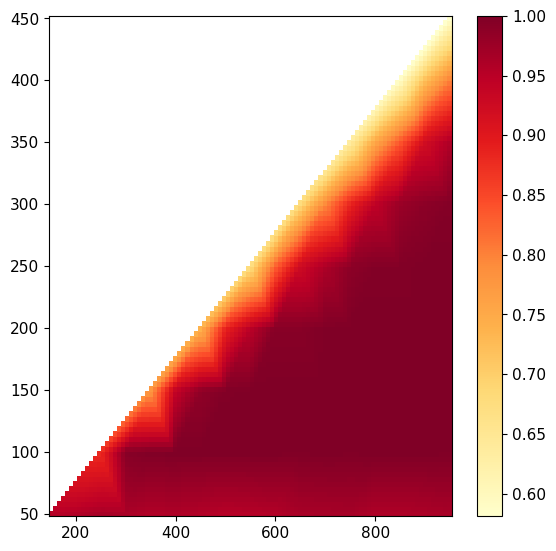

In [18]:
graph2d_array(
    *masses.T, efficiency, colorbar=True, interp=True,
)

In [19]:
gen_bkg = Background(name='bkg')

In [20]:
import pickle 

def write_generator(generator : Generator, size=100, stage='training'):
    ttree = generator(size=size)

    

    with open(f"data/{stage}/{generator.name}.pkl", 'wb') as f:
        pickle.dump(ttree, f)



In [21]:
!rm -f data/training/* data/testing/*

In [22]:
import multiprocess as mp
import functools as ft
import utils.resources as rsc

generators = list(gen_sig.values())

with mp.Pool(4) as pool:
    list(tqdm(pool.imap_unordered( ft.partial(write_generator, size=int(50000 // len(generators)), stage='training'), generators), total=len(generators)))
write_generator(gen_bkg, size=50000, stage='training')


with mp.Pool(4) as pool:
    list(tqdm(pool.imap_unordered( ft.partial(write_generator, size=int(10000 // len(generators)), stage='testing'), generators), total=len(generators)))
write_generator(gen_bkg, size=10000, stage='testing')

100%|██████████| 81/81 [00:28<00:00,  2.87it/s]


In [9]:
!pwd

/home/ekoenig/analysis/studies


In [10]:
gen_bkg().y2_m

<Array [167] type='1 * float64'>